## Notes on common unsupervised learning methods
- Perform PCA, K-means clustering, and hierarchical clustering on several datasets

In [2]:
'''data'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder

'''Clustering methods'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import scipy.cluster.hierarchy as shc

## PCA
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

**Import**

In [3]:
data = pd.read_csv("data/USArrests.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'State'}, inplace=True)

In [5]:
data.shape

(50, 5)

**This dataset contains 5 features and no response variables measured across 50 observations.**

In [6]:
data.describe() # column means

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


**Thoughts**
- Varibales have vastly different variances because they have different scales.
- UrbanPop meausres the percentage of population in each state living in the urban area.
- Murder, Assualt, and Rape are number of each incident per 100,000 individuals in each state. 
- Especially for PCA, we need to perform scaling of the features, since they uses different units.  Otherwise, most of the weights computed from the PCA algorithm will be assigned to Assault (feature with the largest mean and stdev)

**Standardize the data**

In [7]:
scaler = StandardScaler()
processed = scaler.fit_transform(data[["Murder", "Assault", "UrbanPop", "Rape"]]) # exclude "State"

In [8]:
n_samples = data.shape[0] # number of observations
n_features = data.shape[1]-1 # number of features (exclude "State")

**PCA**

In [9]:
# n_components is the number of principal components (m).  I set it to the number of features that I have (exclude State).
pca = PCA(n_components = n_features) 
pca.fit(processed)
processed= pca.transform(processed)

In [10]:
processed.shape

(50, 4)

**Look at the PVE (proportion of variance explained) of each PC.  We conclude that 0.86 of the total variation in the data is explained by the first two PCs.**
- PVE of PC1 = Var(PC1)/(Var(PC1) + Var(PC2) + Var(PC3) + Var(PC4))

In [11]:
print(pca.explained_variance_ratio_) 

[0.62006039 0.24744129 0.0891408  0.04335752]


**PCA loadings**

In [12]:
pca.components_ # the PCA loadings (contribution of each original feature to the new derived variables)

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

In [13]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=data.columns.values[1:])

In [14]:
loadings

,PC1,PC2,PC3,PC4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


**Find the correlation between the original variable (ex: Murder) and the derived variable (ex: PC1).**
- We see from the below matrix, it is 0.85
- We compute the correlation matrix from (loadings) * sqrt(PVE)

In [15]:
correlations = pca.components_.T * np.sqrt(pca.explained_variance_)

corr_matrix = pd.DataFrame(correlations, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=data.columns.values[1:])

In [16]:
corr_matrix

,PC1,PC2,PC3,PC4
Murder,0.852545,0.420259,-0.205829,0.273115
Assault,0.927768,0.188920,-0.161745,-0.312735
UrbanPop,0.442565,-0.877144,-0.228016,0.056319
Rape,0.864528,-0.168150,0.493277,0.037451


**Plotting**

Text(0.5, 1.0, 'Principal Component Analysis of the US Arrest Dataset')

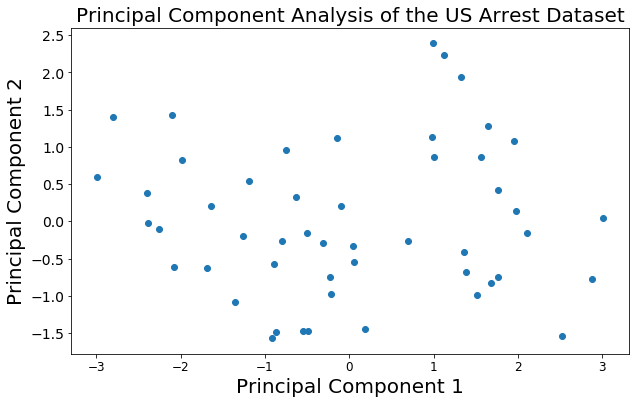

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(processed[:,0], processed[:,1])

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of the US Arrest Dataset",fontsize=20)


**Plot of the cumulative explained variance**

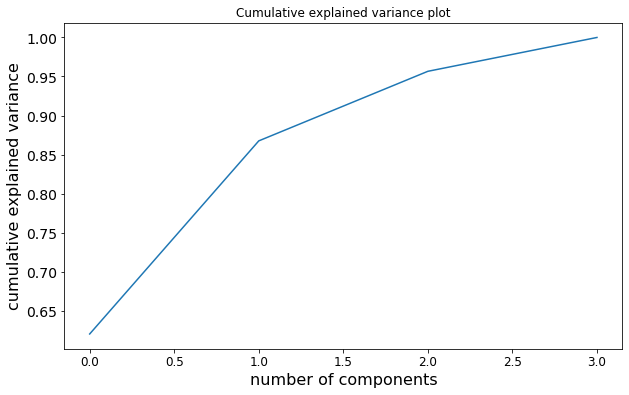

In [18]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title("Cumulative explained variance plot");

**Scree plot**

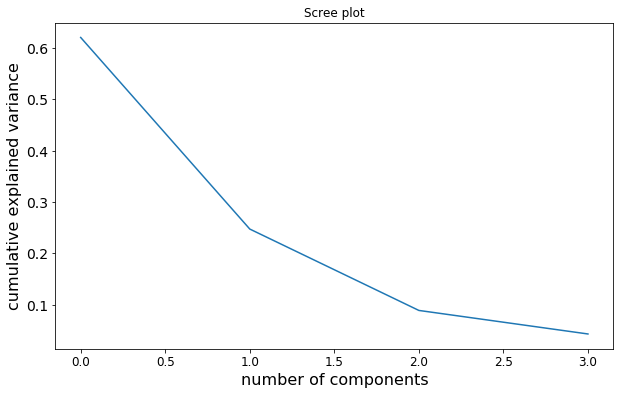

In [19]:
plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ratio_)

plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title("Scree plot");

**Elbow occurs around the fourth to fifth PC.  Therefore, perhaps only 4 PC is sufficient in capturing most of the total variance in the data.**

## Perform PCA on the "glass" dataset

In [20]:
data = pd.read_csv('data/glass.csv').drop('id',axis=1)
data.head()

,ri,na,mg,al,si,k,ca,ba,fe,type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [21]:
data.type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: type, dtype: int64

In [22]:
set(data.type)

{1, 2, 3, 5, 6, 7}

**There are 9 features and 1 response variable (in real life, since this is an unsupervised problem, we wouldn't have a response variable").  There are 6 classes, so we know that the observations are "actually" clustered into 6 groups.**

In [23]:
feature_names = data.columns.values[:-1]

In [24]:
# Standardize the features
scaler = StandardScaler()
processed = scaler.fit_transform(data[feature_names])

In [25]:
# n_components is the number of principal components (m)
# I set it to be same as the number of features. Usually n_components = min(n-1, number_of_features)
pca = PCA(n_components = 9) 
processed = pca.fit_transform(processed)

**Derive 9 principal components from the 9 features.  Using the the first two PCs, I plot the obesrvations in a 2-D feature space.** 

In [26]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 
                                                    'PC6', 'PC7', 'PC8', 'PC9'], index=feature_names)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
ri,0.545177,0.285683,0.086911,0.147381,-0.073543,0.115288,0.081867,-0.752216,0.025732
na,-0.258126,0.270350,-0.384920,0.491242,0.153683,-0.558118,0.148580,-0.127693,-0.311937
mg,0.110881,-0.593558,0.008418,0.378786,0.123509,0.308186,-0.206045,-0.076891,-0.577273
al,-0.428709,0.295212,0.329237,-0.137506,0.014109,-0.018857,-0.699236,-0.274441,-0.192227
si,-0.228836,-0.155099,-0.458709,-0.652538,0.008500,0.086098,0.216067,-0.379923,-0.298073
k,-0.219344,-0.153970,0.662574,-0.038535,-0.307040,-0.243632,0.504121,-0.109812,-0.260509
ca,0.492306,0.345380,-0.000985,-0.276443,-0.188188,-0.148669,-0.099135,0.398705,-0.579323
ba,-0.250375,0.484702,0.074055,0.133175,0.251334,0.657219,0.351783,0.144932,-0.198228
fe,0.185842,-0.062039,0.284451,-0.230492,0.873264,-0.243044,0.073721,-0.016271,-0.014669


In [27]:
PVE = pd.DataFrame(pca.explained_variance_ratio_, columns = ["PVE"], index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 
                                                    'PC6', 'PC7', 'PC8', 'PC9'])

In [28]:
print(PVE) 

          PVE
PC1  0.279018
PC2  0.227786
PC3  0.156094
PC4  0.128651
PC5  0.101556
PC6  0.058626
PC7  0.040995
PC8  0.007095
PC9  0.000179


**Plotting**

Text(0.5, 1.0, 'Principal Component Analysis of the Glass Dataset')

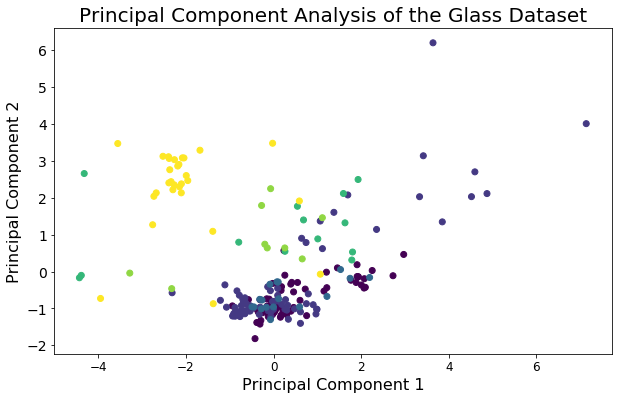

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(processed[:,0], processed[:,1], c= data.type) # color represents the actual classes

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=16)
plt.ylabel('Principal Component 2',fontsize=16)
plt.title("Principal Component Analysis of the Glass Dataset",fontsize=20)

**Plot of the cumulative explained variance**

Text(0, 0.5, 'cumulative explained variance')

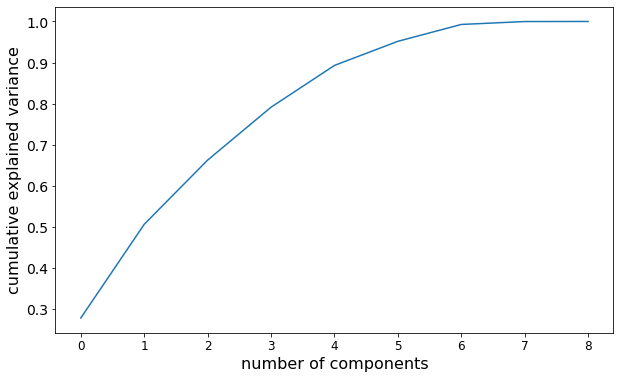

In [30]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)

## K-means clustering
- Cluster observations into K groups (K is specified by the user) on the basis of the features.
- Initially, randomly assign a number from 1-K to each of the observations. 
- Iterate until the cluster assignments stop changing (or up to a max number of iterations specified by the user):
    - For each of the K clusters, compute the cluster centroid (a px1 vector that contains the mean of each feature for a cluster).
    - Assign each observation to the cluster whose centroid is closest (where closest is defined using Eclidean distance).
    
- After the algorithm iterates many times, the cluster assignments will stop changing and I have reached a local minimum. There might be different local minimums, the local minima that I reached is dependent on my starting random cluster assignment.
- Thus, I need to run the algorithm multiple times from different random starting cluster assignments. To get the global minimum, I need to choose amongst the different local minimums for the clustering that yields the smallest total within cluster variance.
- The total within cluster variance is computed by the following steps:
    - Find the squared Eucliean distance between all possible paris of observation in the kth cluster, sum them up. Divide the sum by the total number of observations in the cluster. 
    - Repeat above to each of the k clusters.
    - Finally I find the total within cluster variation of all K clusters.

In [31]:
kmeans= KMeans(n_clusters = 6, # specify 6 clusters (the true number of classes in the actual glass data)
               n_init = 10, # the number of times the k-means algorithm will run with different initializations
               max_iter = 300, # the number of iterations the k-means algorithm will have for a SINGLE run (default= 300)
               random_state = 10,
               verbose = 2,
               n_jobs = -1)

In [32]:
# Fit model
kmeans.fit(processed) # used the 9 derived variables from PCA

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=2)

In [33]:
pred = kmeans.predict(processed)

In [34]:
pred # a "label" is now assigned to each of the observations (1-6)

array([1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 5, 5, 0, 0, 0, 1, 1, 0, 5, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       5, 0, 5, 1, 1, 0, 1, 5, 0, 0, 0, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 5, 0, 0, 0, 5, 5, 0, 0, 5, 0, 5, 1, 1, 3, 3, 3, 1, 0,
       3, 3, 3, 5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 1, 5, 1, 1, 3,
       0, 5, 0, 5, 5, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0, 0, 0, 0, 5, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 5, 5, 2, 0, 3, 3, 0, 0, 0, 3, 4, 4, 3, 5, 5,
       1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

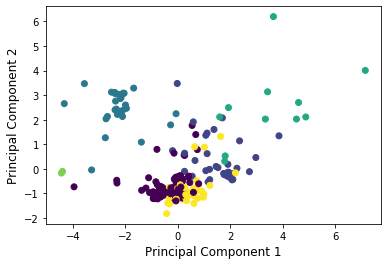

In [35]:
plt.scatter(processed[:,0],processed[:,1],c=pred) # labels from k-means clustering
plt.xlabel('Principal Component 1',fontsize=12)
plt.ylabel('Principal Component 2',fontsize=12);

**Try clustering with K=3 groups**

In [36]:
kmeans= KMeans(n_clusters = 3, # specify 3 clusters (the true number of classes in the actual glass data)
               n_init = 10, # the number of times the k-means algorithm will run with different initializations
               max_iter = 300, # the number of iterations the k-means algorithm will have for a SINGLE run (default= 300)
               random_state = 10,
               verbose = 2,
               n_jobs = -1)

In [37]:
# Train model
pred = kmeans.fit_predict(processed) # used derived features from PCA

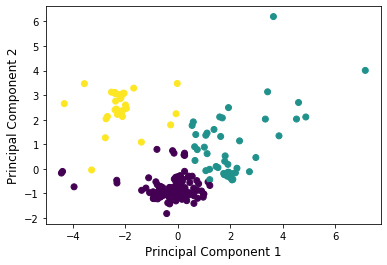

In [38]:
plt.scatter(processed[:,0],processed[:,1],c=pred) # labels from k-means clustering
plt.xlabel('Principal Component 1',fontsize=12)
plt.ylabel('Principal Component 2',fontsize=12);

- There are 9 features for this dataset.  
- However, we can plot the observations in a 2-D feature space beause we performed PCA, and then plot the observations in the PC1-PC2 feature space.
- In general, if there were more than two variables in your dataset, you can first perform PCA and then plot the first two PCs (derived variables) for visualization.
- The class label assigned/predicted by the K-means algorithm to each observation is represented by a color. 

## DBSCAN
- A very popular unsupervised learning method. 
- I need to tune hyperparameters.
- Number of cluster is predicted by the algorithm and NOT set by the user.

In [39]:
dbscan= DBSCAN(eps=1.2, 
               min_samples=3)  ## init DBSCAN object

In [40]:
pred_dbs = dbscan.fit_predict(processed)  ## Perform scaling and PCA, then apply DBSCAN to the derived variables

In [41]:
pred_dbs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, -1, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1,  2,  2,  3,  3,  2,  2,  2,  2,  2,  2, -1,  2,  3,
        2,  3,  3, -1,  2,  2,  3,  3,  3,  3], dtype=int64)

In [42]:
set(pred_dbs)

{-1, 0, 1, 2, 3}

**DBSCAN gives me only 5 groups**

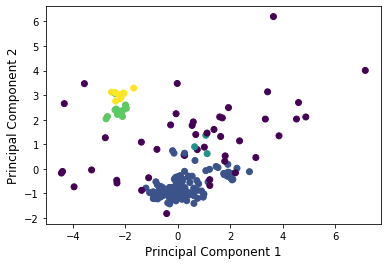

In [43]:
plt.scatter(processed[:,0], processed[:,1], c=pred_dbs) 
plt.xlabel('Principal Component 1',fontsize=12)
plt.ylabel('Principal Component 2',fontsize=12);

## Hierarchical Clustering
- Perform hierarchical clustering
- Plot the clustering dendrogram using complete, single, and average linkage, with Euclidean distance as the dissimilarity measure.

Ref: https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

- In the dataset, for columns, I have multiple product categories – Fresh, Milk, Grocery, etc. 
- The values represent the number of units purchased by each client for each product. 
- Our aim is to cluster this data to segment similar clients together. 
- We will use Hierarchical Clustering for this problem.

**Import**

In [44]:
data = pd.read_csv("data/Wholesale customers data.csv")

In [45]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Before applying Hierarchical Clustering, we have to normalize the data so that the scale of each variable is the same. Why is this important? If the scale of the variables is not the same, the model might become biased towards the variables with a higher magnitude like Fresh or Milk.** 

In [46]:
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.000112,0.000168,0.708333,0.539874,0.422741,0.011965,0.149505,0.074809
1,0.000125,0.000188,0.442198,0.614704,0.599540,0.110409,0.206342,0.111286
2,0.000125,0.000187,0.396552,0.549792,0.479632,0.150119,0.219467,0.489619
3,0.000065,0.000194,0.856837,0.077254,0.272650,0.413659,0.032749,0.115494
4,0.000079,0.000119,0.895416,0.214203,0.284997,0.155010,0.070358,0.205294


**Let’s first draw the dendrogram to help us decide the number of clusters for this particular problem.**

Text(0.5, 1.0, 'Dendrograms')

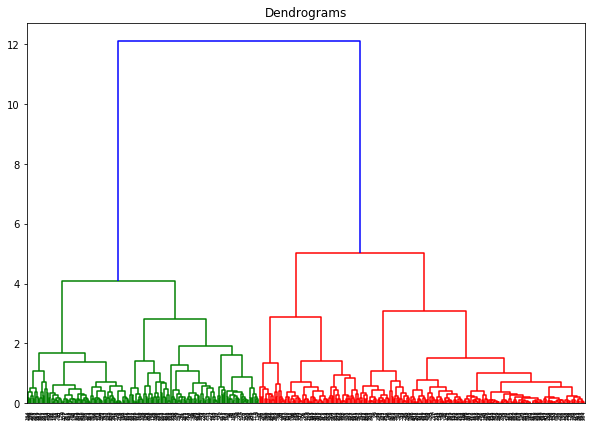

In [47]:
plt.figure(figsize=(10, 7))  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.title("Dendrograms")  

- The x-axis contains the samples and y-axis represents the Euclidean distance between these samples. 
- The algorithm will stop once one big (single group) cluster is formed. 
- Next, we examine the dendrogram. We identify the longest vertical line without any horizontal line passing through it. Then we draw a horizontal line that intersects with this vertical line. 
- The number of vertical lines of the dendrogram this newly created horizontal line passes is equal to number of clusters.
- We see from the above steps, we identify 6 as the max dissimiliar measure (min Euclidean distance) between the clusters.
- We have 2 clusters.

In [48]:
linked = shc.linkage(data_scaled, 
                    # "single", "centroid", "median", ‘complete’, ‘average’, ‘weighted', 'ward'
                     method = 'ward',
                     # braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, 
                     # ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, 
                     # ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, 
                     # ‘sqeuclidean’, ‘yule’
                     metric = 'euclidean') 

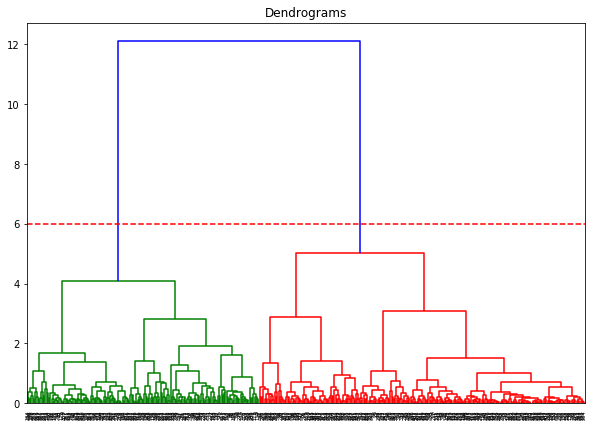

In [49]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(linked)
plt.axhline(y=6, color='r', linestyle='--')

**Let's apply hierarchical clustering for 2 clusters.**

In [50]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=2,  # number of clusters
                                  affinity='euclidean', # disimiliarity measure
                                  linkage='ward')  # linkage method 

pred = cluster.fit_predict(data_scaled)  # Can also use cluster.labels_

In [51]:
pred # We use HC to predict/assign a class label to each observation

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

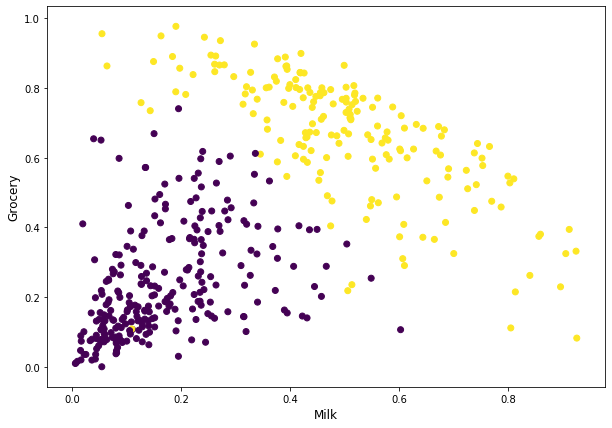

In [52]:
# We plot data in a 2-D feature space (use "Milk" and "Grocery")
# We set color to the cluster labels
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['Milk'], data_scaled['Grocery'], c=cluster.labels_)  # use hierarchical clustering
plt.xlabel('Milk',fontsize=12)
plt.ylabel('Grocery',fontsize=12);

## Clustering on the NCI60 dataset
- Consists of 6,830 gene expression measurements on 64 cancer cell lines.
- 64 observations, 6830 features-- thus I have a high-dimensional setting.

In [53]:
data = pd.read_csv('data/NCI60.csv').drop("Unnamed: 0", axis=1)
data.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830,labs
0,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654981,...,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000,CNS
1,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285020,...,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039,CNS
2,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,...,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000,CNS
3,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,...,-0.110000,-0.160000,0.095000,-0.350020,-0.300000,-1.150010,1.090000,-0.260000,-1.100000,RENAL
4,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,...,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000,BREAST


In [54]:
data.labs.value_counts()

RENAL          9
NSCLC          9
MELANOMA       8
COLON          7
BREAST         7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
MCF7A-repro    1
K562B-repro    1
MCF7D-repro    1
UNKNOWN        1
K562A-repro    1
Name: labs, dtype: int64

In [55]:
set(data.labs) # 14 classes

{'BREAST',
 'CNS',
 'COLON',
 'K562A-repro',
 'K562B-repro',
 'LEUKEMIA',
 'MCF7A-repro',
 'MCF7D-repro',
 'MELANOMA',
 'NSCLC',
 'OVARIAN',
 'PROSTATE',
 'RENAL',
 'UNKNOWN'}

In [56]:
data.shape

(64, 6831)

In [57]:
# Encode the labels
enc = LabelEncoder()
data["labs_encoded"] = enc.fit_transform(data.labs)

**We first perform PCA on the data after scaling the variables (genes) to have standard deviation one, although one could reasonably argue that it is better not to scale the genes.**

In [58]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:,:-2])
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.values[:-2])
data_scaled.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6821,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830
0,0.728671,1.607220,1.325688,1.355688,-0.604845,-0.220654,0.898137,-0.868741,-1.058612,-1.059174,...,-1.030663,-0.358518,-0.238245,-0.392487,0.831370,-0.200286,-0.075668,0.520893,-0.836365,-1.384675
1,1.596418,1.753544,0.441686,0.654119,0.911898,1.648748,1.849697,2.226625,-0.095860,-0.477977,...,-0.215657,-0.625720,-0.489938,-0.800791,0.013818,-1.105413,-1.117676,-0.823652,-0.925425,-1.431446
2,2.190290,-0.016217,-0.349092,0.266465,-1.311310,-0.019322,0.191185,1.988627,1.007979,0.716019,...,0.452274,-0.251651,-0.930304,-0.868790,-0.583517,-0.331142,-0.075668,0.008704,-0.960951,-0.095838
3,0.682995,-0.375502,1.628079,-0.444299,1.244434,-0.019322,0.408709,0.798057,0.045135,0.119051,...,-1.313667,-0.456479,-0.409013,-0.086293,-0.709285,-0.494711,-1.034286,1.558075,-0.693981,-0.830408
4,1.151170,-0.581759,0.965145,1.138767,0.361351,-0.033703,0.177590,0.396239,0.550041,2.310550,...,0.718297,-1.048700,-0.728079,-0.556925,0.839231,0.492157,-0.075668,1.116312,0.525182,0.000992


In [59]:
n_samples = data.shape[0] # number of observations
n_features = data.shape[1]-2 # number of features (exclude "labs" and "labs_ecnoded")

In [60]:
# I set n_component to min(n_samples = 64, n_features = 6830) = 64
pca = PCA(n_components = min(n_samples, n_features))  # 64 observations with 64 derived features
pca.fit(data_scaled)
processed= pca.transform(data_scaled)

In [61]:
pca.components_.shape  # I have 64 derived variables (PCs) from 6830 original variables. So I have 64x6830 loadings

(64, 6830)

**Plot of the cumulative explained variance**

Text(0.5, 1.0, 'Cumulative explained variance plot')

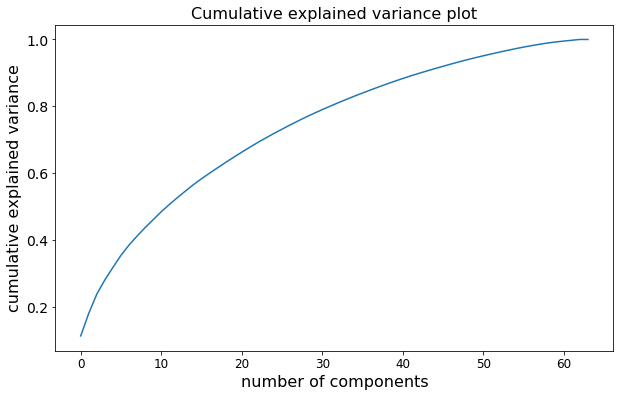

In [62]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.title('Cumulative explained variance plot', fontsize=16)

Text(0.5, 1.0, 'Scree plot')

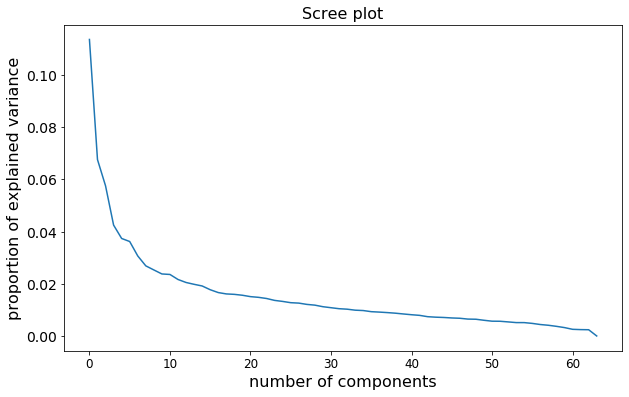

In [63]:
plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ratio_)

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('proportion of explained variance', fontsize=16)
plt.title('Scree plot', fontsize=16)

In [64]:
pca.explained_variance_ratio_[:5] # The PVE of the first 5 PCs

array([0.11358942, 0.06756203, 0.05751842, 0.04247554, 0.03734972])

**Thoughts**
- From the scree plot (PVE vs number of PCs), we see that there is an "elbow" at n_components =7. Thus, after PC7, the PVE of each subsequent PC is small.
- From the cumulative variance plot, the first 7 PC explain close to 40% of the total variation in the observations.

**Plot observations in the PC1-PC2 feature space**

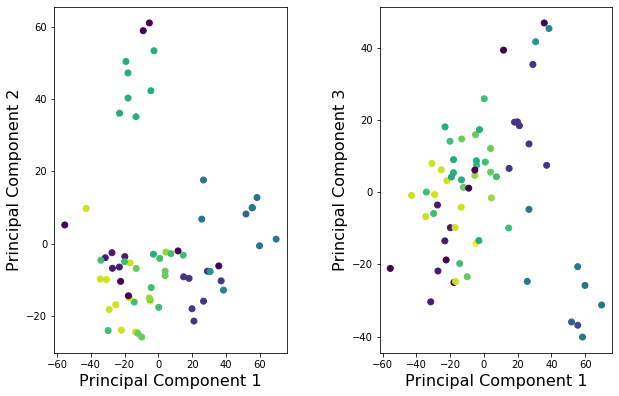

In [65]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].scatter(processed[:,0], processed[:,1], c= data.labs_encoded)
ax[0].set_xlabel('Principal Component 1',fontsize=16)
ax[0].set_ylabel('Principal Component 2',fontsize=16)


ax[1].scatter(processed[:,0], processed[:,2], c= data.labs_encoded)
ax[1].set_xlabel('Principal Component 1',fontsize=16)
ax[1].set_ylabel('Principal Component 3',fontsize=16)
# fig.tight_layout()

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.55)

**Thoughts**
- Projections of the NCI60 cancer cell lines onto the first three principal components (in other words, the scores for the first three principal components).
- On the whole, observations belonging to a single cancer type tend to lie near each other in this low-dimensional space.
- It would not have been possible to visualize the data without using a dimension reduction method such as PCA since there would have been two many possible pairs of features (too many scatterplots and none of them are informative).

## Hierarchical clustering of the NCI60 data
- Standardize the data
- Plot the dendrogram using complete linkage, average linkage, and single linkage. We use Euclidean distance as the dissimilarity measure.
- Perform hierarchical clustering
- The goal is to find out whether or not the observations cluster into distinct types of cancer.

In [66]:
data = pd.read_csv('data/NCI60.csv').drop("Unnamed: 0", axis=1)
data.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830,labs
0,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654981,...,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000,CNS
1,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285020,...,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039,CNS
2,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,...,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000,CNS
3,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,...,-0.110000,-0.160000,0.095000,-0.350020,-0.300000,-1.150010,1.090000,-0.260000,-1.100000,RENAL
4,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,...,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000,BREAST


In [67]:
# Encode the labels
enc = LabelEncoder()
data["labs_encoded"] = enc.fit_transform(data.labs)

In [68]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:,:-2])
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.values[:-2])
data_scaled.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6821,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830
0,0.728671,1.607220,1.325688,1.355688,-0.604845,-0.220654,0.898137,-0.868741,-1.058612,-1.059174,...,-1.030663,-0.358518,-0.238245,-0.392487,0.831370,-0.200286,-0.075668,0.520893,-0.836365,-1.384675
1,1.596418,1.753544,0.441686,0.654119,0.911898,1.648748,1.849697,2.226625,-0.095860,-0.477977,...,-0.215657,-0.625720,-0.489938,-0.800791,0.013818,-1.105413,-1.117676,-0.823652,-0.925425,-1.431446
2,2.190290,-0.016217,-0.349092,0.266465,-1.311310,-0.019322,0.191185,1.988627,1.007979,0.716019,...,0.452274,-0.251651,-0.930304,-0.868790,-0.583517,-0.331142,-0.075668,0.008704,-0.960951,-0.095838
3,0.682995,-0.375502,1.628079,-0.444299,1.244434,-0.019322,0.408709,0.798057,0.045135,0.119051,...,-1.313667,-0.456479,-0.409013,-0.086293,-0.709285,-0.494711,-1.034286,1.558075,-0.693981,-0.830408
4,1.151170,-0.581759,0.965145,1.138767,0.361351,-0.033703,0.177590,0.396239,0.550041,2.310550,...,0.718297,-1.048700,-0.728079,-0.556925,0.839231,0.492157,-0.075668,1.116312,0.525182,0.000992


**Dendrograms (complete linkage)**

In [69]:
linked = shc.linkage(data_scaled, 
                     method = 'complete',
                     metric = 'euclidean') 

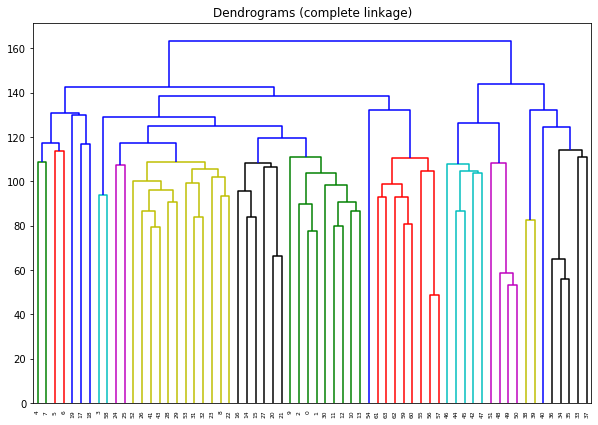

In [70]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms (complete linkage)")  
dend = shc.dendrogram(linked)

**Dendrograms (average linkage)**

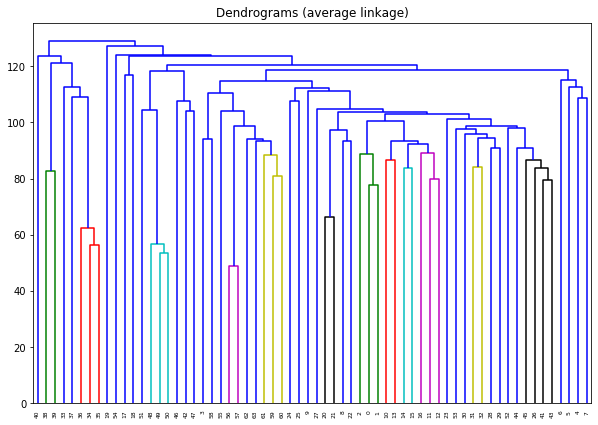

In [71]:
linked = shc.linkage(data_scaled, 
                     method = 'average',
                     metric = 'euclidean') 

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms (average linkage)")  
dend = shc.dendrogram(linked)

**Dendrograms (single linkage)**

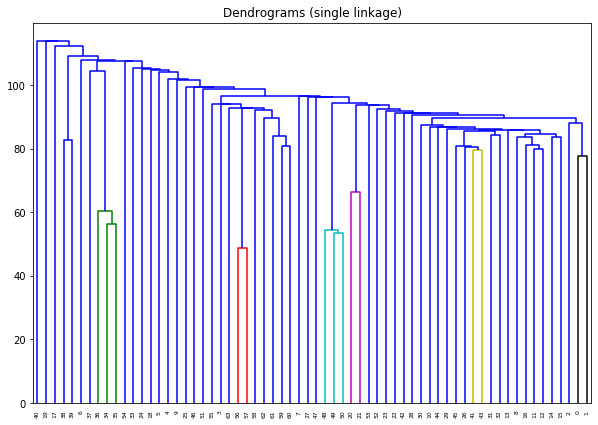

In [72]:
linked = shc.linkage(data_scaled, 
                     method = 'single',
                     metric = 'euclidean') 

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms (single linkage)")  
dend = shc.dendrogram(linked)

**Thoughts**
- From the above dendrograms, we see that the choice of linkage affect the results obtained. 
- Typically, single linkage will tend to yield trailing clusters: very large clusters onto which individual observations
attach one-by-one. 
- On the other hand, complete and average linkage tend to yield more even-sized and balanced clusters. 
- For this reason, complete and average linkage are generally preferred to single linkage.

**Cut the dendrogram**

- From the dendrograms, cell lines within a single cancer type do tend to cluster together, although the clustering is not perfect. We will use complete linkage hierarchical clustering for the analysis that follows.
- We can cut the dendrogram at the height that will yield a particular number of clusters, say four ( min Ecludiean distance between cluster = 140).

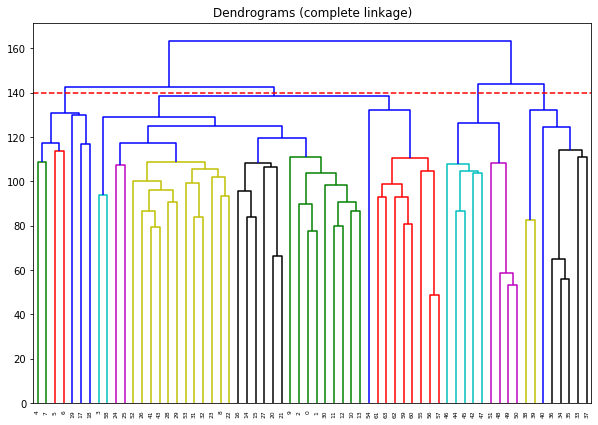

In [73]:
linked = shc.linkage(data_scaled, 
                     method = 'complete',
                     metric = 'euclidean') 

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms (complete linkage)")  
dend = shc.dendrogram(linked)
plt.axhline(y=140, color='r', linestyle='--')

In [74]:
cluster = AgglomerativeClustering(n_clusters=4,  # number of clusters
                                  affinity='euclidean', # disimiliarity measure
                                  linkage='complete')  # linkage method 

pred = cluster.fit_predict(data_scaled)  # Can also use cluster.labels_

In [75]:
pred

array([0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

**Perform PCA, then clustering**

- Rather than performing hierarchical clustering on the entire data matrix, we can simply perform hierarchical clustering on the first few principal component score vectors.
- Sometimes performing clustering on the first few principal component score vectors can give better results than performing clustering on the full data. In this situation, we might view the principal component step as one of denoising the data. We could also perform K-means clustering on the first few principal component score vectors rather than the full data set.

**PCA**

In [76]:
n_samples = data_scaled.shape[0] # number of observations
n_features = data_scaled.shape[1] # number of features 

In [77]:
# n_components = min(n_samples = 64, n_features = 6830)
pca = PCA(n_components = min(n_samples, n_features))  # Thus, I have 64 derived variables, and 64 observations
pca.fit(data_scaled)
processed= pca.transform(data_scaled)

In [78]:
processed.shape # 64 observations, with 6830 features that is "summarized" by 64 derived features.

(64, 64)

**Perform hierarchical clustering on the derived features**

In [79]:
cluster = AgglomerativeClustering(n_clusters=4,  # number of clusters
                                  affinity='euclidean', # disimiliarity measure
                                  linkage='complete')  # linkage method 

pred = cluster.fit_predict(processed)  # Can also use cluster.labels_

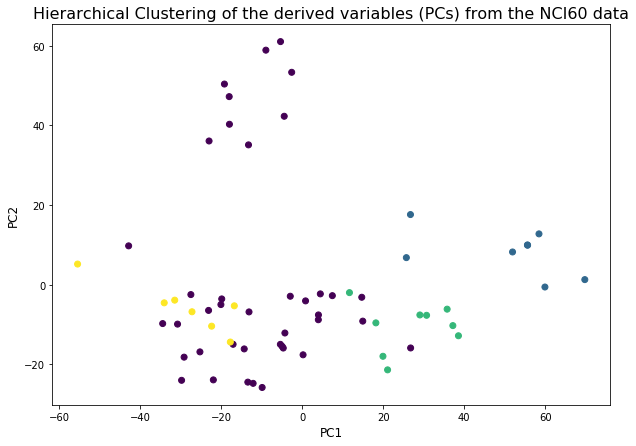

In [80]:
# We plot data in a 2-D feature space (use PC1 and PC2)
# We set color to the cluster labels
plt.figure(figsize=(10, 7))  
plt.scatter(processed[:,0], processed[:,1], c=cluster.labels_)  # clusters predicted by hierarchical clustering
plt.xlabel('PC1',fontsize=12) 
plt.ylabel('PC2',fontsize=12)
plt.title("Hierarchical Clustering of the derived variables (PCs) from the NCI60 data", fontsize=16);

**Perform K-means on the derived features**

In [81]:
kmeans= KMeans(n_clusters = 4, # specify 4 clusters 
               n_init = 10, # the number of times the k-means algorithm will run with different initializations
               max_iter = 300, # the number of iterations the k-means algorithm will have for a SINGLE run (default= 300)
               random_state = 10,
               verbose = 2,
               n_jobs = -1)

In [82]:
pred = kmeans.fit_predict(processed) # clustered on data processed with PCA

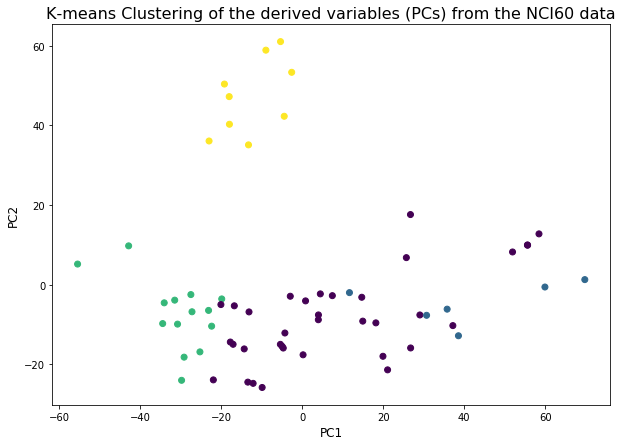

In [83]:
plt.figure(figsize=(10, 7))  
plt.scatter(processed[:,0],processed[:,1],c=pred) # k-means clusters
plt.xlabel('PC1',fontsize=12)
plt.ylabel('PC2',fontsize=12)
plt.title("K-means Clustering of the derived variables (PCs) from the NCI60 data", fontsize=16);

- In general, the four clusters obtained using hierarchical clustering and Kmeans clustering are somewhat different. 